# Cargo Theft Data Clustering - Run 2

In [1]:
# Start with magic
%matplotlib inline

# Import the necessary dependencies.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Get the Crime Report data.
df = pd.read_csv("../Datasets/CrimeReport.csv")
df.head()

,data_year,pub_agency_name,agency_type_name,state_name,division_name,county_name,region_name,population_group_code,population_group_desc,offense_code,...,location_code,location_name,weapon_code,weapon_name,prop_desc_code,prop_desc_name,stolen_value,recovered_value,recovered_flag,date_recovered
0,2021,Angelina,County,Texas,West South Central,ANGELINA,South,8B,"Non-MSA counties from 25,000 thru 99,999",26B,...,25,Other/Unknown,95,Unknown,20,Money,375.0,0,False,NaN
1,2021,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,"MSA counties 100,000 or over",23H,...,20,Residence/Home,95,Unknown,77,Other,1.0,0,False,NaN
2,2021,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,"MSA counties 100,000 or over",23H,...,20,Residence/Home,95,Unknown,65,Identity Documents,0.0,0,False,NaN
3,2021,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,"MSA counties 100,000 or over",23H,...,20,Residence/Home,95,Unknown,13,Firearms,320.0,0,False,NaN
4,2021,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,"MSA counties 100,000 or over",23F,...,20,Residence/Home,95,Unknown,77,Other,1.0,0,False,NaN


In [3]:
# Drop the unused columns.
dropped = ["data_year", "pub_agency_name", "agency_type_name",
           "division_name", "county_name", "region_name",
           "offender_race", "offender_ethnicity", "offender_age",
           "offender_sex", "weapon_code", "weapon_name", "date_recovered"]
df0 = df.drop(columns = dropped, axis = 1)
df0.head()

,state_name,population_group_code,population_group_desc,offense_code,offense_name,victim_type_code,victim_type_name,location_code,location_name,prop_desc_code,prop_desc_name,stolen_value,recovered_value,recovered_flag
0,Texas,8B,"Non-MSA counties from 25,000 thru 99,999",26B,Credit Card/Automated Teller Machine Fraud,I,Individual,25,Other/Unknown,20,Money,375.0,0,False
1,Alabama,9A,"MSA counties 100,000 or over",23H,All Other Larceny,I,Individual,20,Residence/Home,77,Other,1.0,0,False
2,Alabama,9A,"MSA counties 100,000 or over",23H,All Other Larceny,I,Individual,20,Residence/Home,65,Identity Documents,0.0,0,False
3,Alabama,9A,"MSA counties 100,000 or over",23H,All Other Larceny,I,Individual,20,Residence/Home,13,Firearms,320.0,0,False
4,Alabama,9A,"MSA counties 100,000 or over",23F,Theft From Motor Vehicle,I,Individual,20,Residence/Home,77,Other,1.0,0,False


In [4]:
# This time, leave out the outliers.
df1 = df0.loc[df0.stolen_value < 10000000]

## I. First Selection - The Stolen Values of Objects as a Whole

In [5]:
# Set up the DataFrame.
stolen_df = df1[["state_name", "population_group_code", "offense_code", "victim_type_code",
                 "location_code", "prop_desc_code", "stolen_value"]]
stolen_df.head()

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value
0,Texas,8B,26B,I,25,20,375.0
1,Alabama,9A,23H,I,20,77,1.0
2,Alabama,9A,23H,I,20,65,0.0
3,Alabama,9A,23H,I,20,13,320.0
4,Alabama,9A,23F,I,20,77,1.0


In [6]:
# Null values should have been dealt with, but are there any duplicates again?
stolen_df.duplicated().sum()

24695

In [7]:
# Deal with the duplicates.
stolen_df = stolen_df.drop_duplicates()

## II. Second Selection - Look at the Recovered Subset

In [8]:
# Set up the DataFrame.
recov_df = df1.loc[df1.recovered_flag == True][["state_name", "population_group_code", "offense_code",
                                                "victim_type_code", "location_code", "prop_desc_code",
                                                "stolen_value", "recovered_value"]]
recov_df.head()

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value,recovered_value
16,Alabama,9B,23H,I,20,9,0.0,0
42,West Virginia,9A,23H,I,25,77,5000.0,5000
46,Alabama,2,240,I,20,3,12000.0,12000
49,Alabama,2,240,I,20,3,11000.0,11000
66,Alabama,2,240,I,18,3,20000.0,20000


In [9]:
# This time, focus only on non-zero stolen values.
recov_df = recov_df.loc[recov_df.stolen_value > 0]

In [10]:
# Find the recovery percentage.
recov_df["recovery_rate"] = (recov_df.recovered_value / recov_df.stolen_value)
recov_df.head()

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value,recovered_value,recovery_rate
42,West Virginia,9A,23H,I,25,77,5000.0,5000,1.0
46,Alabama,2,240,I,20,3,12000.0,12000,1.0
49,Alabama,2,240,I,20,3,11000.0,11000,1.0
66,Alabama,2,240,I,18,3,20000.0,20000,1.0
83,Alabama,2,220,B,14,37,15000.0,15000,1.0


In [11]:
# Null values should have been dealt with, but are there any duplicates again?
recov_df.duplicated().sum()

4038

In [12]:
# Deal with the duplicates.
recov_df = recov_df.drop_duplicates()

## Ready and Run the PCA

In [13]:
# Use get_dummies() to handle the categorical features.
features = ["state_name", "population_group_code", "offense_code", "victim_type_code"]
X_stolen = pd.get_dummies(stolen_df, columns = features)
X_recov = pd.get_dummies(recov_df, columns = features)

print(X_stolen.shape)
print(X_recov.shape)

(98253, 101)
(12491, 97)


In [14]:
# Standardize the data with StandardScaler().
stolenX_scaled = StandardScaler().fit_transform(X_stolen)
recovX_scaled = StandardScaler().fit_transform(X_recov)

In [15]:
# Use PCA to reduce the stolen values DataFrame to three principal components.
pca = PCA(n_components = 3, random_state = 0) # Use Random State of 0 for this one.
pca_stolen = pca.fit_transform(stolenX_scaled)

# Put the results into a DataFrame.
stolenpca_df = pd.DataFrame(data = pca_stolen, columns = ["PC 1", "PC 2", "PC 3"], index = X_stolen.index)
print(stolenpca_df.shape)
stolenpca_df.head(10)

(98253, 3)


,PC 1,PC 2,PC 3
0,-0.751042,1.238815,-0.069762
1,-0.896586,-0.792156,-0.015092
2,-0.897429,-0.769086,-0.020261
3,-0.900495,-0.669129,-0.042436
4,-1.229483,-0.140653,-1.192975
5,-1.230327,-0.117583,-1.198145
6,-1.233393,-0.017626,-1.220320
7,-1.193053,0.245485,0.845654
8,-1.194596,0.262809,0.841429
9,-1.225323,0.543672,0.092021


In [16]:
# Use PCA to reduce the recovered values DataFrame to three principal components.
pca_recov = pca.fit_transform(recovX_scaled)

# Put the results into a DataFrame.
recovpca_df = pd.DataFrame(data = pca_recov, columns = ["PC 1", "PC 2", "PC 3"], index = X_recov.index)
print(recovpca_df.shape)
recovpca_df.head(10)

(12491, 3)


,PC 1,PC 2,PC 3
42,-0.556552,0.220606,1.026803
46,-0.278800,1.341847,-1.949900
49,-0.291170,1.333871,-1.951690
66,-0.170786,1.400620,-1.935959
83,0.885390,-1.013388,-0.133214
87,1.271164,-0.690327,-1.469558
91,-0.532862,0.836225,-0.379872
95,-0.147089,1.159286,-1.716217
104,-0.485911,0.348093,0.086105
106,-0.198144,0.047604,-0.089016


## Cluster the Data with K-Means

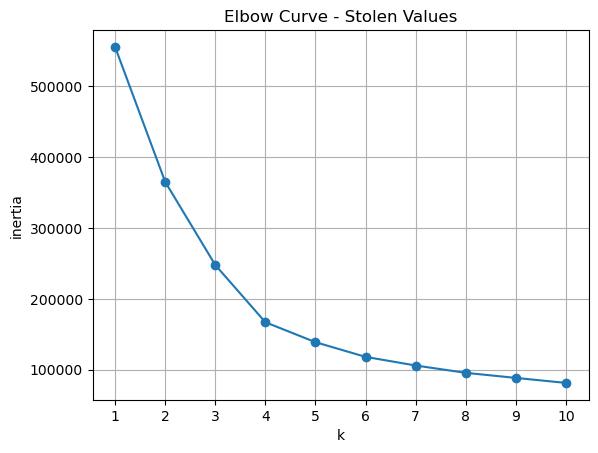

In [17]:
# Create an elbow curve to find the best value for K.
inertia = []
K = list(range(1, 11))
for i in K:
    kmeanmodel = KMeans(n_clusters = i, random_state = 1).fit(stolenpca_df)
    inertia.append(kmeanmodel.inertia_)

# Plot
fig, ax = plt.subplots()

ax.plot(K, inertia, "o-")

ax.set(xlabel = "k", ylabel = "inertia", title = "Elbow Curve - Stolen Values")

ax.grid()

ax.set_xticks(K)

plt.savefig("../Images/StolenValues_ElbowCurve_2.png")

plt.show()

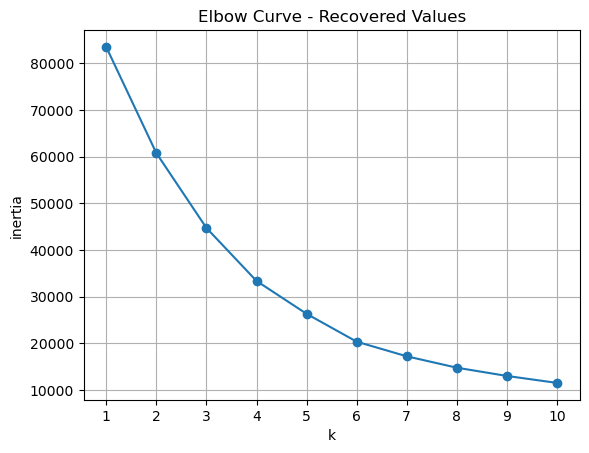

In [18]:
# Do this again with the other DataFrame.
inertia = []
K = list(range(1, 11))
for i in K:
    kmeanmodel = KMeans(n_clusters = i, random_state = 1).fit(recovpca_df)
    inertia.append(kmeanmodel.inertia_)

# Plot
fig, ax = plt.subplots()

ax.plot(K, inertia, "o-")

ax.set(xlabel = "k", ylabel = "inertia", title = "Elbow Curve - Recovered Values")

ax.grid()

ax.set_xticks(K)

plt.savefig("../Images/RecoveredValues_ElbowCurve_2.png")

plt.show()

### Use Four Clusters When Running K-Means

In [19]:
# Initialize the K-Means model.
model = KMeans(n_clusters = 4, random_state = 0) # Use Random State of 0 for this one.

# Fit the model
model.fit(stolenpca_df)

# Predict clusters
stoleny_pred = model.predict(stolenpca_df)
stoleny_pred

array([1, 1, 1, ..., 2, 2, 2])

In [20]:
# Create the stolen values cluster DataFrame.
stolen_cluster = stolen_df.join(stolenpca_df, how = "left")
stolen_cluster["Class"] = model.labels_
stolen_cluster.head(10)

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value,PC 1,PC 2,PC 3,Class
0,Texas,8B,26B,I,25,20,375.0,-0.751042,1.238815,-0.069762,1
1,Alabama,9A,23H,I,20,77,1.0,-0.896586,-0.792156,-0.015092,1
2,Alabama,9A,23H,I,20,65,0.0,-0.897429,-0.769086,-0.020261,1
3,Alabama,9A,23H,I,20,13,320.0,-0.900495,-0.669129,-0.042436,1
4,Alabama,9A,23F,I,20,77,1.0,-1.229483,-0.140653,-1.192975,1
5,Alabama,9A,23F,I,20,65,0.0,-1.230327,-0.117583,-1.198145,1
6,Alabama,9A,23F,I,20,13,320.0,-1.233393,-0.017626,-1.220320,1
7,Alabama,2,220,I,20,26,900.0,-1.193053,0.245485,0.845654,0
8,Alabama,2,220,I,20,17,400.0,-1.194596,0.262809,0.841429,0
9,Alabama,2,23F,I,25,38,9900.0,-1.225323,0.543672,0.092021,0


In [21]:
# Do this again with the other DataFrame.
model.fit(recovpca_df)

recovy_pred = model.predict(recovpca_df)
recovy_pred

array([2, 2, 2, ..., 0, 0, 0])

In [22]:
# Create the recovered values cluster DataFrame.
recover_cluster = recov_df.join(recovpca_df, how = "left")
recover_cluster["Class"] = model.labels_
recover_cluster.head(10)

,state_name,population_group_code,offense_code,victim_type_code,location_code,prop_desc_code,stolen_value,recovered_value,recovery_rate,PC 1,PC 2,PC 3,Class
42,West Virginia,9A,23H,I,25,77,5000.0,5000,1.0,-0.556552,0.220606,1.026803,2
46,Alabama,2,240,I,20,3,12000.0,12000,1.0,-0.278800,1.341847,-1.949900,2
49,Alabama,2,240,I,20,3,11000.0,11000,1.0,-0.291170,1.333871,-1.951690,2
66,Alabama,2,240,I,18,3,20000.0,20000,1.0,-0.170786,1.400620,-1.935959,2
83,Alabama,2,220,B,14,37,15000.0,15000,1.0,0.885390,-1.013388,-0.133214,0
87,Alabama,2,240,B,18,37,15000.0,15000,1.0,1.271164,-0.690327,-1.469558,1
91,Alabama,2,220,I,14,37,15000.0,15000,1.0,-0.532862,0.836225,-0.379872,2
95,Alabama,2,240,I,18,37,15000.0,15000,1.0,-0.147089,1.159286,-1.716217,2
104,Alabama,2,23D,I,5,75,450.0,450,1.0,-0.485911,0.348093,0.086105,2
106,Alabama,2,23H,I,5,75,450.0,450,1.0,-0.198144,0.047604,-0.089016,2


In [23]:
# Export these DataFrames for others to use.
stolen_cluster.to_csv("../Resources/clusters_stolen_2.csv", index = False)
recover_cluster.to_csv("../Resources/clusters_recover_2.csv", index = False)

## Visualize the Clusters
### See the Clusters in 3D

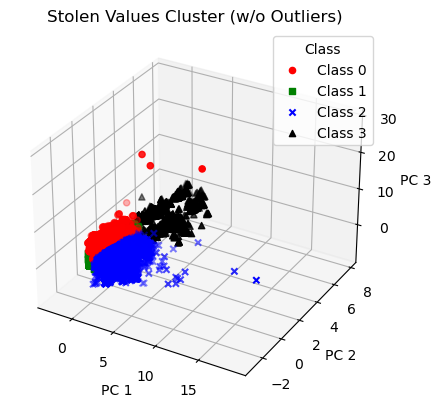

In [24]:
# Create the 3D Scatterplot for the stolen values clusters
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")

x0 = stolen_cluster.loc[stolen_cluster.Class == 0]["PC 1"]
y0 = stolen_cluster.loc[stolen_cluster.Class == 0]["PC 2"]
z0 = stolen_cluster.loc[stolen_cluster.Class == 0]["PC 3"]
x1 = stolen_cluster.loc[stolen_cluster.Class == 1]["PC 1"]
y1 = stolen_cluster.loc[stolen_cluster.Class == 1]["PC 2"]
z1 = stolen_cluster.loc[stolen_cluster.Class == 1]["PC 3"]
x2 = stolen_cluster.loc[stolen_cluster.Class == 2]["PC 1"]
y2 = stolen_cluster.loc[stolen_cluster.Class == 2]["PC 2"]
z2 = stolen_cluster.loc[stolen_cluster.Class == 2]["PC 3"]
x3 = stolen_cluster.loc[stolen_cluster.Class == 3]["PC 1"]
y3 = stolen_cluster.loc[stolen_cluster.Class == 3]["PC 2"]
z3 = stolen_cluster.loc[stolen_cluster.Class == 3]["PC 3"]

ax.scatter(x0, y0, z0, color = "r", marker = "o", label = "Class 0")
ax.scatter(x1, y1, z1, color = "g", marker = "s", label = "Class 1")
ax.scatter(x2, y2, z2, color = "b", marker = "x", label = "Class 2")
ax.scatter(x3, y3, z3, color = "k", marker = "^", label = "Class 3")

ax.set(xlabel = "PC 1", ylabel = "PC 2", zlabel = "PC 3", title = "Stolen Values Cluster (w/o Outliers)")

ax.legend(title = "Class", loc = "best")

plt.savefig("../Images/StolenValues_3DScatter_2.png")

plt.show()

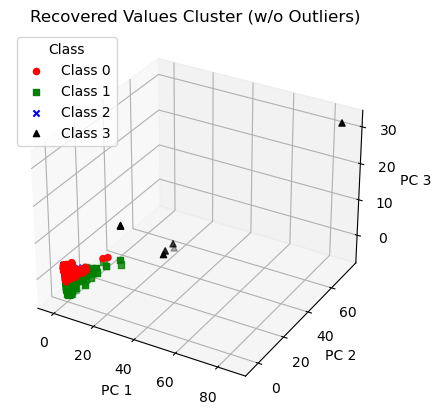

In [25]:
# Create the 3D Scatterplot for the recovered values clusters
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")

x0 = recover_cluster.loc[recover_cluster.Class == 0]["PC 1"]
y0 = recover_cluster.loc[recover_cluster.Class == 0]["PC 2"]
z0 = recover_cluster.loc[recover_cluster.Class == 0]["PC 3"]
x1 = recover_cluster.loc[recover_cluster.Class == 1]["PC 1"]
y1 = recover_cluster.loc[recover_cluster.Class == 1]["PC 2"]
z1 = recover_cluster.loc[recover_cluster.Class == 1]["PC 3"]
x2 = recover_cluster.loc[recover_cluster.Class == 2]["PC 1"]
y2 = recover_cluster.loc[recover_cluster.Class == 2]["PC 2"]
z2 = recover_cluster.loc[recover_cluster.Class == 2]["PC 3"]
x3 = recover_cluster.loc[recover_cluster.Class == 3]["PC 1"]
y3 = recover_cluster.loc[recover_cluster.Class == 3]["PC 2"]
z3 = recover_cluster.loc[recover_cluster.Class == 3]["PC 3"]

ax.scatter(x0, y0, z0, color = "r", marker = "o", label = "Class 0")
ax.scatter(x1, y1, z1, color = "g", marker = "s", label = "Class 1")
ax.scatter(x2, y2, z2, color = "b", marker = "x", label = "Class 2")
ax.scatter(x3, y3, z3, color = "k", marker = "^", label = "Class 3")

ax.set(xlabel = "PC 1", ylabel = "PC 2", zlabel = "PC 3", title = "Recovered Values Cluster (w/o Outliers)")

ax.legend(title = "Class", loc = "best")

plt.savefig("../Images/RecoveredValues_3DScatter_2.png")

plt.show()

### Flatten the 3D Plot

In [26]:
# Scale the data
minmaxs = MinMaxScaler().fit_transform(stolen_cluster[["prop_desc_code", "stolen_value"]])
minmaxr = MinMaxScaler().fit_transform(recover_cluster[["stolen_value", "recovered_value"]])

# Set up the plot DataFrames
plots_df = pd.DataFrame(minmaxs, columns = ["Prop. Desc. Code", "Stolen Value"])
plotr_df = pd.DataFrame(minmaxr, columns = ["Stolen Value", "Recovered Value"])

# Add any other columns as needed
plots_df["Class"] = stolen_cluster["Class"]
plotr_df["Class"] = recover_cluster["Class"].reset_index(drop = True)

In [27]:
plots_df.head(10)

,Prop. Desc. Code,Stolen Value,Class
0,0.193878,4.166667e-05,1.0
1,0.775510,1.111111e-07,1.0
2,0.653061,0.000000e+00,1.0
3,0.122449,3.555556e-05,1.0
4,0.775510,1.111111e-07,1.0
5,0.653061,0.000000e+00,1.0
6,0.122449,3.555556e-05,1.0
7,0.255102,1.000000e-04,0.0
8,0.163265,4.444444e-05,0.0
9,0.377551,1.100000e-03,0.0


In [28]:
plotr_df.head(10)

,Stolen Value,Recovered Value,Class
0,0.001666,0.001667,2
1,0.004000,0.004000,2
2,0.003666,0.003667,2
3,0.006666,0.006667,2
4,0.005000,0.005000,0
5,0.005000,0.005000,1
6,0.005000,0.005000,2
7,0.005000,0.005000,2
8,0.000150,0.000150,2
9,0.000150,0.000150,2


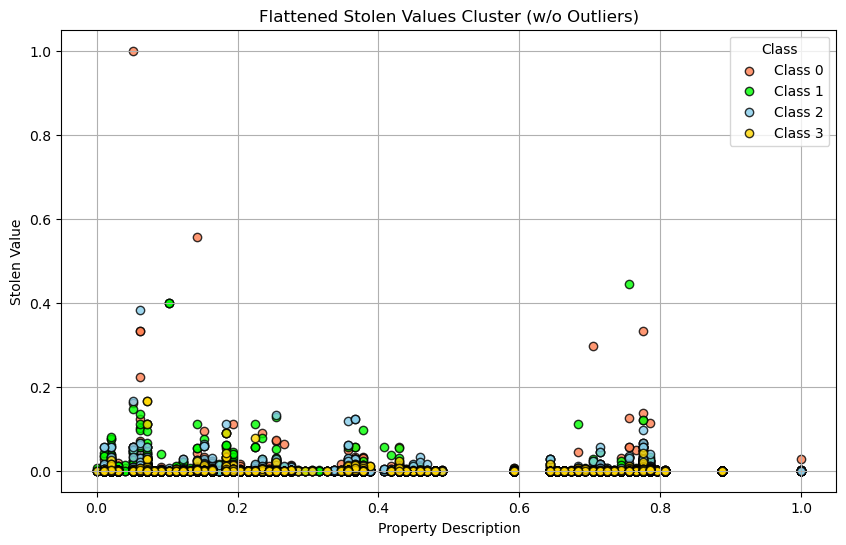

In [29]:
# Make the flattened plot
plt.subplots(figsize = (10, 6))

plt.scatter(plots_df.loc[plots_df.Class == 0]["Prop. Desc. Code"],
            plots_df.loc[plots_df.Class == 0]["Stolen Value"],
            color = "coral", edgecolor = "black", linewidths = 1,
            alpha = 0.8, label = "Class 0")
plt.scatter(plots_df.loc[plots_df.Class == 1]["Prop. Desc. Code"],
            plots_df.loc[plots_df.Class == 1]["Stolen Value"],
            color = "lime", edgecolor = "black", linewidths = 1,
            alpha = 0.8, label = "Class 1")
plt.scatter(plots_df.loc[plots_df.Class == 2]["Prop. Desc. Code"],
            plots_df.loc[plots_df.Class == 2]["Stolen Value"],
            color = "skyblue", edgecolor = "black", linewidths = 1,
            alpha = 0.8, label = "Class 2")
plt.scatter(plots_df.loc[plots_df.Class == 3]["Prop. Desc. Code"],
            plots_df.loc[plots_df.Class == 3]["Stolen Value"],
            color = "gold", edgecolor = "black", linewidths = 1,
            alpha = 0.8, label = "Class 3")

plt.title("Flattened Stolen Values Cluster (w/o Outliers)")
plt.xlabel("Property Description")
plt.ylabel("Stolen Value")
plt.grid(True)

plt.legend(title = "Class", loc= "best")

plt.savefig("../Images/StolenValues_FlatPlot_2.png")

plt.show()

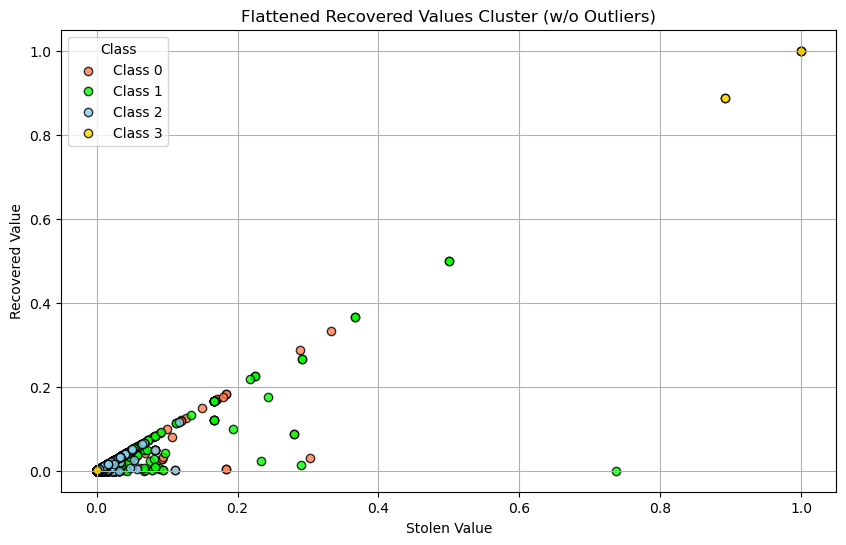

In [30]:
# Make the flattened plot
plt.subplots(figsize = (10, 6))

plt.scatter(plotr_df.loc[plotr_df.Class == 0]["Stolen Value"],
            plotr_df.loc[plotr_df.Class == 0]["Recovered Value"],
            color = "coral", edgecolor = "black", linewidths = 1,
            alpha = 0.8, label = "Class 0")
plt.scatter(plotr_df.loc[plotr_df.Class == 1]["Stolen Value"],
            plotr_df.loc[plotr_df.Class == 1]["Recovered Value"],
            color = "lime", edgecolor = "black", linewidths = 1,
            alpha = 0.8, label = "Class 1")
plt.scatter(plotr_df.loc[plotr_df.Class == 2]["Stolen Value"],
            plotr_df.loc[plotr_df.Class == 2]["Recovered Value"],
            color = "skyblue", edgecolor = "black", linewidths = 1,
            alpha = 0.8, label = "Class 2")
plt.scatter(plotr_df.loc[plotr_df.Class == 3]["Stolen Value"],
            plotr_df.loc[plotr_df.Class == 3]["Recovered Value"],
            color = "gold", edgecolor = "black", linewidths = 1,
            alpha = 0.8, label = "Class 3")

plt.title("Flattened Recovered Values Cluster (w/o Outliers)")
plt.xlabel("Stolen Value")
plt.ylabel("Recovered Value")
plt.grid(True)

plt.legend(title = "Class", loc= "best")

plt.savefig("../Images/RecoveredValues_FlatPlot_2.png")

plt.show()